<a href="https://colab.research.google.com/github/sk160902/2.Bayesian-NNs-via-MCMC/blob/main/saidl_project_Bayesian_inferenceipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gpflow

     |████████████████████████████████| 287 kB 5.2 MB/s 


In [ ]:
pip install -U scikit-learn scipy matplotlib

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.2 MB 37.4 MB/s 
     |████████████████████████████████| 895 kB 49.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install matplotlib==3.1.1


     |████████████████████████████████| 13.1 MB 4.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable


gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)
%matplotlib inline

In [ ]:
#from multiclass_classification import plot_from_samples, colors

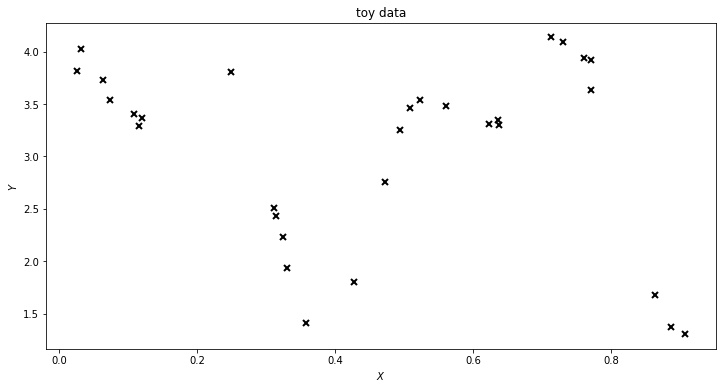

In [ ]:
#1.preparing a dataset for noisy XOR problem and splitting them into train and test
df = np.random.binomial(n=1,p=0.5,size=1000)
N=30
def synthetic_data(num: int, df: np.random.RandomState):
    X = df.rand(num, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + df.randn(num, 1) * 0.1 + 3
    return X, Y

data = (X, Y) = synthetic_data(N,rng)

plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.title("toy data")
plt.show()



In [ ]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 800
No. of testing examples: 200


In [ ]:
#2.Implementing a prior, likelihood and posterior function for MLP parameters
params=np.linspace(0,1,100)
params

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:
# Implementing prior
p_prior=np.array([np.product(st.bernoulli.pmf(df,p)) for p in params])

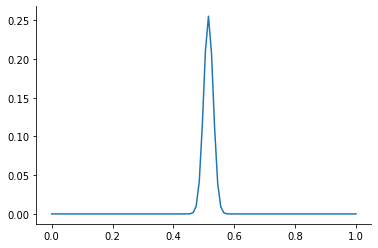

In [ ]:
p_prior=p_prior/np.sum(p_prior)
plt.plot(params,p_prior)
sns.despine()

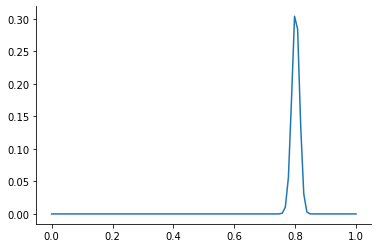

In [ ]:
#Implementing likelihood
df_likelihood=np.random.binomial(n=1,p=0.8,size=1000)
p_likelihood=np.array([np.product(st.bernoulli.pmf(df_likelihood,p)) for p in params])
p_likelihood=p_likelihood/np.sum(p_likelihood)
plt.plot(params,p_likelihood)
sns.despine()

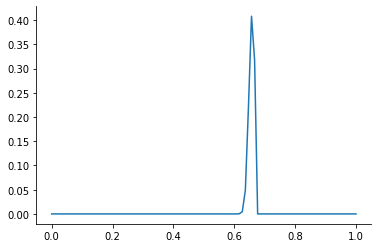

In [ ]:
#implementing posterior
p_posterior=[p_prior[i]*p_likelihood[i] for i in range (len(p_prior))]
p_posterior=p_posterior/np.sum(p_posterior)
plt.plot(params,p_posterior)
sns.despine()

In [ ]:
#building the GPR model.

kernel = gpflow.kernels.Matern52(lengthscales=0.3)
mean_function = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, mean_function, noise_variance=0.01)

In [ ]:
#initializing the model to the maximum likelihood solution.
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)

print(f"log posterior density at optimum: {model.log_posterior_density()}")




log posterior density at optimum: -2.4371366970695973


In [ ]:
# adding priors to hyperparameters
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.mean_function.A.prior = tfd.Normal(f64(0.0), f64(10.0))
model.mean_function.b.prior = tfd.Normal(f64(0.0), f64(10.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,Normal,True,"(1, 1)",float64,[[-1.06377032]]
GPR.mean_function.b,Parameter,Identity,Normal,True,(),float64,3.54746034440015
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9357531803032095
GPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.10390237142109658
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.005756764054347076


In [ ]:
#now sample from the posterior using HMC(Hamiltonian Monte Carlo).

num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

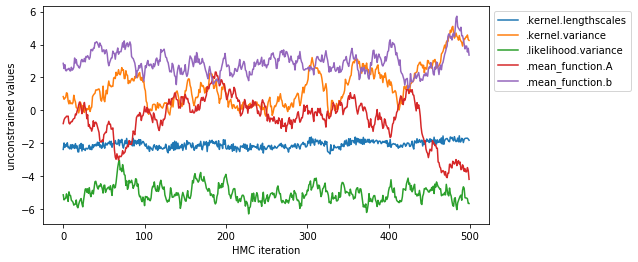

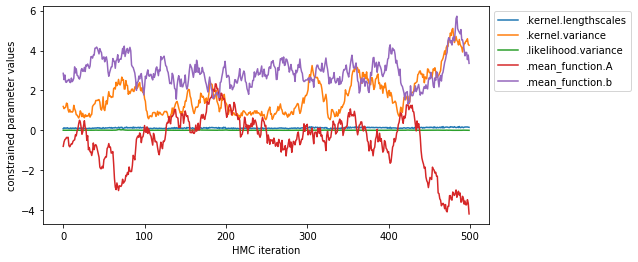

In [ ]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


plot_samples(samples, model.trainable_parameters, "unconstrained values")
plot_samples(parameter_samples, model.trainable_parameters, "constrained parameter values")

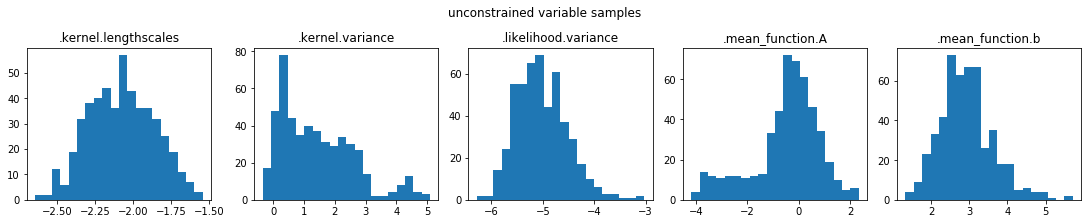

In [ ]:
#inspecting marginal distribution of parameters
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label)
    plt.show()


marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")

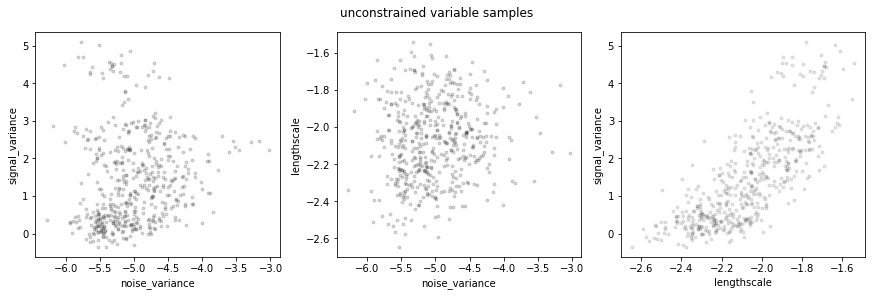

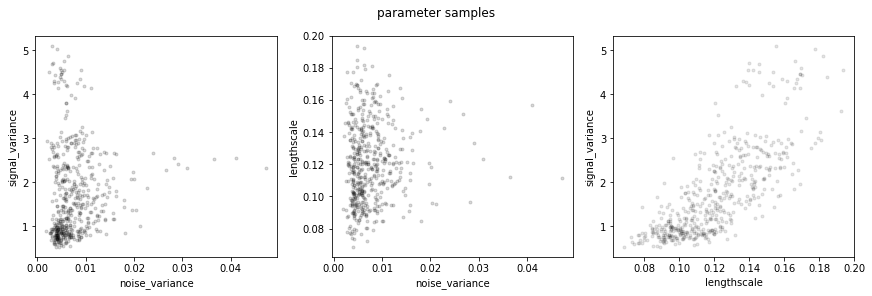

In [ ]:
def plot_joint_marginals(samples, parameters, y_axis_label):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    axs[0].set_xlabel("noise_variance")
    axs[0].set_ylabel("signal_variance")

    axs[1].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    axs[1].set_xlabel("noise_variance")
    axs[1].set_ylabel("lengthscale")

    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    axs[2].set_xlabel("lengthscale")
    axs[2].set_ylabel("signal_variance")
    f.suptitle(y_axis_label)
    plt.show()


plot_joint_marginals(samples, model.trainable_parameters, "unconstrained variable samples")
plot_joint_marginals(parameter_samples, model.trainable_parameters, "parameter samples")

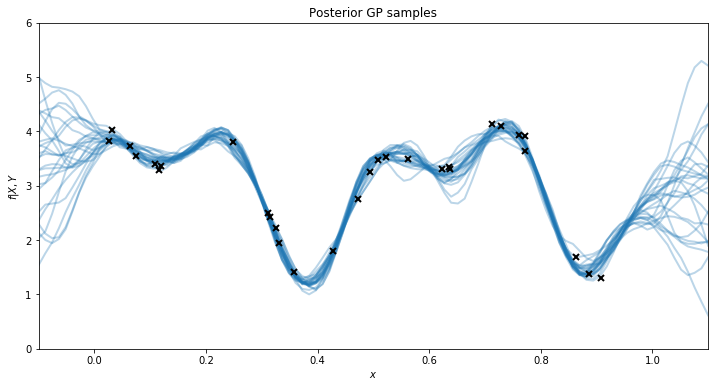

In [ ]:
# plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:, None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xx, 1)
    plt.plot(xx, f[0, :, :], "C0", lw=2, alpha=0.3)

plt.plot(X, Y, "kx", mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("Posterior GP samples")

plt.show()

Ensemble prediction

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=10000, n_features=10, centers=100,random_state=0)

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()





True

In [4]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9997

In [5]:

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean() > 0.999
True

True